In [ ]:

# 1. Import Required Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve
)

#.Make plots look nicer
sns.set(style="whitegrid")


In [ ]:

# 2. Generate Telecom Churn Dataset 


import numpy as np
import pandas as pd

rng = np.random.default_rng(42)
n = 7043  # similar size to  Telco churn datasets

def choice(a, p=None, size=n):
    return rng.choice(a, size=size, p=p)

# Core demographics
gender = choice(["Female", "Male"], p=[0.5, 0.5])
SeniorCitizen = rng.binomial(1, 0.16, size=n) 
Partner = choice(["Yes", "No"], p=[0.48, 0.52])
Dependents = choice(["Yes", "No"], p=[0.30, 0.70])

# Services
PhoneService = choice(["Yes", "No"], p=[0.90, 0.10])
MultipleLines = np.where(
    PhoneService == "No",
    "No phone service",
    choice(["Yes", "No"], p=[0.42, 0.58])
)

InternetService = choice(["Fiber optic", "DSL", "No"], p=[0.44, 0.41, 0.15])

def service_feature():
    # If no internet -> "No internet service", else Yes/No
    base = choice(["Yes", "No"], p=[0.35, 0.65])
    return np.where(InternetService == "No", "No internet service", base)

OnlineSecurity = service_feature()
OnlineBackup = service_feature()
DeviceProtection = service_feature()
TechSupport = service_feature()
StreamingTV = service_feature()
StreamingMovies = service_feature()

# Contract & billing
Contract = choice(["Month-to-month", "One year", "Two year"], p=[0.55, 0.23, 0.22])
PaperlessBilling = choice(["Yes", "No"], p=[0.60, 0.40])
PaymentMethod = choice(
    ["Electronic check", "Mailed check", "Bank transfer (automatic)", "Credit card (automatic)"],
    p=[0.34, 0.23, 0.22, 0.21]
)

# Tenure (months) – depends on contract a bit
tenure = np.zeros(n, dtype=int)
for i in range(n):
    if Contract[i] == "Month-to-month":
        tenure[i] = int(np.clip(rng.gamma(shape=2.0, scale=6.0), 0, 72))  # shorter
    elif Contract[i] == "One year":
        tenure[i] = int(np.clip(rng.gamma(shape=3.0, scale=8.0), 0, 72))
    else:
        tenure[i] = int(np.clip(rng.gamma(shape=4.0, scale=10.0), 0, 72))
tenure = np.maximum(tenure, 1)  # avoid 0 tenure

# MonthlyCharges – influenced by Internet type + add-ons
base_charge = (
    np.where(InternetService == "No", 20, 0) +
    np.where(InternetService == "DSL", 45, 0) +
    np.where(InternetService == "Fiber optic", 75, 0)
).astype(float)

addons = (OnlineSecurity == "Yes").astype(int) + (OnlineBackup == "Yes").astype(int) + \
         (DeviceProtection == "Yes").astype(int) + (TechSupport == "Yes").astype(int) + \
         (StreamingTV == "Yes").astype(int) + (StreamingMovies == "Yes").astype(int)

MonthlyCharges = base_charge + addons * rng.uniform(3, 7, size=n) + rng.normal(0, 5, size=n)
MonthlyCharges = np.clip(MonthlyCharges, 18, 120).round(2)

# TotalCharges 
TotalCharges = (MonthlyCharges * tenure + rng.normal(0, 20, size=n)).round(2)
TotalCharges = np.clip(TotalCharges, 0, None)


logit = (
    -1.2
    + 1.0 * (Contract == "Month-to-month").astype(int)
    - 0.045 * tenure
    + 0.35 * (InternetService == "Fiber optic").astype(int)
    + 0.30 * (TechSupport == "No").astype(int)
    + 0.25 * (OnlineSecurity == "No").astype(int)
    + 0.25 * (PaymentMethod == "Electronic check").astype(int)
    + 0.20 * SeniorCitizen
    + 0.008 * (MonthlyCharges - 60)
)

# Convert logit to probability
p_churn = 1 / (1 + np.exp(-logit))
Churn = np.where(rng.random(n) < p_churn, "Yes", "No")

# Build DataFrame
df = pd.DataFrame({
    "gender": gender,
    "SeniorCitizen": SeniorCitizen,
    "Partner": Partner,
    "Dependents": Dependents,
    "tenure": tenure,
    "PhoneService": PhoneService,
    "MultipleLines": MultipleLines,
    "InternetService": InternetService,
    "OnlineSecurity": OnlineSecurity,
    "OnlineBackup": OnlineBackup,
    "DeviceProtection": DeviceProtection,
    "TechSupport": TechSupport,
    "StreamingTV": StreamingTV,
    "StreamingMovies": StreamingMovies,
    "Contract": Contract,
    "PaperlessBilling": PaperlessBilling,
    "PaymentMethod": PaymentMethod,
    "MonthlyCharges": MonthlyCharges,
    "TotalCharges": TotalCharges,
    "Churn": Churn
})


df.to_csv("churn.csv", index=False)

df.head(), df.shape, df["Churn"].value_counts(normalize=True).round(3)


(   gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
 0    Male              0     Yes        Yes      51          Yes   
 1  Female              1     Yes         No       8          Yes   
 2    Male              1      No         No      17          Yes   
 3    Male              0     Yes         No      11          Yes   
 4  Female              0      No         No       5          Yes   
 
   MultipleLines InternetService       OnlineSecurity         OnlineBackup  \
 0           Yes     Fiber optic                  Yes                   No   
 1            No              No  No internet service  No internet service   
 2           Yes     Fiber optic                   No                  Yes   
 3           Yes     Fiber optic                   No                  Yes   
 4           Yes             DSL                   No                  Yes   
 
       DeviceProtection          TechSupport          StreamingTV  \
 0                   No                  Yes 

In [ ]:
#3. Data Understanding


df.shape
df.info()
df.describe()

<class 'pandas.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   str    
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   str    
 3   Dependents        7043 non-null   str    
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   str    
 6   MultipleLines     7043 non-null   str    
 7   InternetService   7043 non-null   str    
 8   OnlineSecurity    7043 non-null   str    
 9   OnlineBackup      7043 non-null   str    
 10  DeviceProtection  7043 non-null   str    
 11  TechSupport       7043 non-null   str    
 12  StreamingTV       7043 non-null   str    
 13  StreamingMovies   7043 non-null   str    
 14  Contract          7043 non-null   str    
 15  PaperlessBilling  7043 non-null   str    
 16  PaymentMethod     7043 non-null   str    
 17  Monthl

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.155616,20.087605,63.881129,1284.417853
std,0.362516,16.185839,23.621317,1206.093805
min,0.000000,1.000000,18.000000,0.000000
25%,0.000000,8.000000,50.130000,415.980000
50%,0.000000,16.000000,64.160000,901.220000
75%,0.000000,28.000000,83.850000,1760.580000
max,1.000000,72.000000,115.410000,8239.330000


In [5]:
#4. target variable distribution
df["Churn"].value_counts()
df["Churn"].value_counts(normalize=True)

Churn
No     0.674429
Yes    0.325571
Name: proportion, dtype: float64

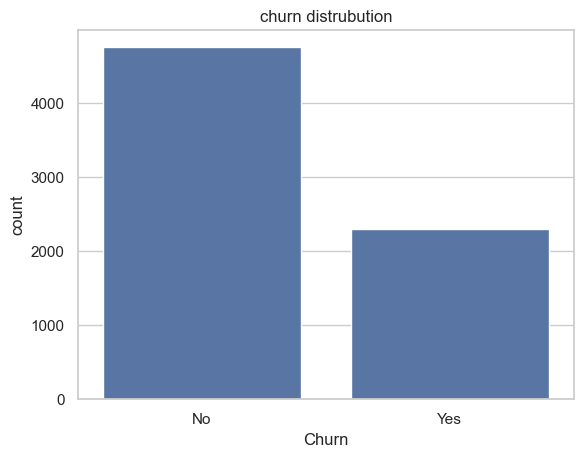

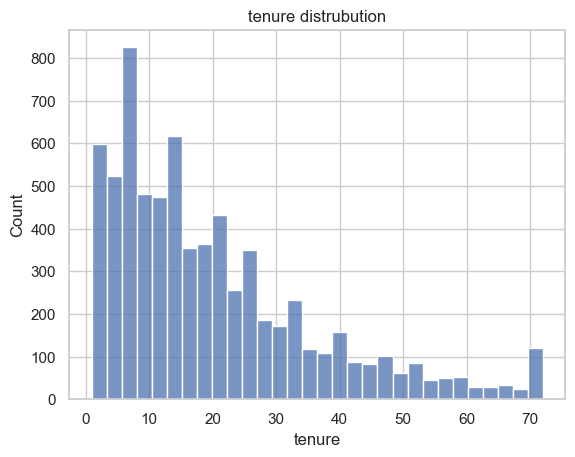

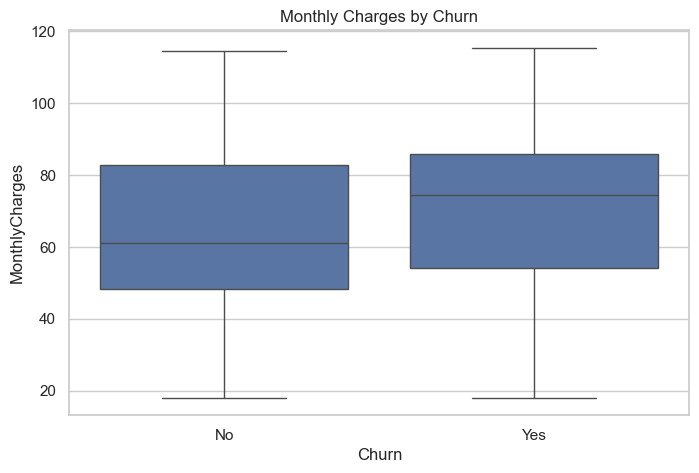

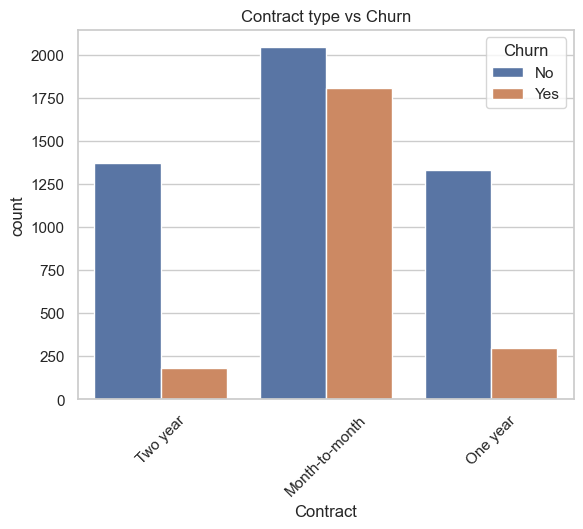

In [9]:
#5. exploratory data analysis
import matplotlib.pyplot as plt
import seaborn as sns

sns.countplot(x="Churn", data=df)
plt.title("churn distrubution")
plt.show()

sns.histplot(df["tenure"], bins=30)
plt.title("tenure distrubution")
plt.show()

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8,5))
sns.boxplot(x="Churn", y="MonthlyCharges", data=df, ax=ax)
ax.set_title("Monthly Charges by Churn")
plt.show()


sns.countplot(x="Contract", hue="Churn", data=df)
plt.title("Contract type vs Churn")
plt.xticks(rotation=45)
plt.show()

In [1]:
import numpy as np
import pandas as pd

rng = np.random.default_rng(42)
n = 7043

def choice(a, p=None, size=n):
    return rng.choice(a, size=size, p=p)

gender = choice(["Female", "Male"])
SeniorCitizen = rng.binomial(1, 0.16, size=n)
Partner = choice(["Yes", "No"], p=[0.48, 0.52])
Dependents = choice(["Yes", "No"], p=[0.30, 0.70])

PhoneService = choice(["Yes", "No"], p=[0.90, 0.10])
MultipleLines = np.where(
    PhoneService == "No",
    "No phone service",
    choice(["Yes", "No"], p=[0.42, 0.58])
)

InternetService = choice(["Fiber optic", "DSL", "No"], p=[0.44, 0.41, 0.15])

def service_feature():
    base = choice(["Yes", "No"], p=[0.35, 0.65])
    return np.where(InternetService == "No", "No internet service", base)

OnlineSecurity = service_feature()
OnlineBackup = service_feature()
DeviceProtection = service_feature()
TechSupport = service_feature()
StreamingTV = service_feature()
StreamingMovies = service_feature()

Contract = choice(["Month-to-month", "One year", "Two year"], p=[0.55, 0.23, 0.22])
PaperlessBilling = choice(["Yes", "No"], p=[0.60, 0.40])
PaymentMethod = choice(
    ["Electronic check", "Mailed check", "Bank transfer (automatic)", "Credit card (automatic)"],
    p=[0.34, 0.23, 0.22, 0.21]
)

tenure = np.zeros(n, dtype=int)
for i in range(n):
    if Contract[i] == "Month-to-month":
        tenure[i] = int(np.clip(rng.gamma(shape=2.0, scale=6.0), 0, 72))
    elif Contract[i] == "One year":
        tenure[i] = int(np.clip(rng.gamma(shape=3.0, scale=8.0), 0, 72))
    else:
        tenure[i] = int(np.clip(rng.gamma(shape=4.0, scale=10.0), 0, 72))
tenure = np.maximum(tenure, 1)

base_charge = (
    np.where(InternetService == "No", 20, 0) +
    np.where(InternetService == "DSL", 45, 0) +
    np.where(InternetService == "Fiber optic", 75, 0)
).astype(float)

addons = (OnlineSecurity == "Yes").astype(int) + (OnlineBackup == "Yes").astype(int) + \
         (DeviceProtection == "Yes").astype(int) + (TechSupport == "Yes").astype(int) + \
         (StreamingTV == "Yes").astype(int) + (StreamingMovies == "Yes").astype(int)

MonthlyCharges = base_charge + addons * rng.uniform(3, 7, size=n) + rng.normal(0, 5, size=n)
MonthlyCharges = np.clip(MonthlyCharges, 18, 120).round(2)

TotalCharges = (MonthlyCharges * tenure + rng.normal(0, 20, size=n)).round(2)
TotalCharges = np.clip(TotalCharges, 0, None)

logit = (
    -1.2
    + 1.0 * (Contract == "Month-to-month").astype(int)
    - 0.045 * tenure
    + 0.35 * (InternetService == "Fiber optic").astype(int)
    + 0.30 * (TechSupport == "No").astype(int)
    + 0.25 * (OnlineSecurity == "No").astype(int)
    + 0.25 * (PaymentMethod == "Electronic check").astype(int)
    + 0.20 * SeniorCitizen
    + 0.008 * (MonthlyCharges - 60)
)

p_churn = 1 / (1 + np.exp(-logit))
Churn = np.where(rng.random(n) < p_churn, "Yes", "No")

df = pd.DataFrame({
    "gender": gender,
    "SeniorCitizen": SeniorCitizen,
    "Partner": Partner,
    "Dependents": Dependents,
    "tenure": tenure,
    "PhoneService": PhoneService,
    "MultipleLines": MultipleLines,
    "InternetService": InternetService,
    "OnlineSecurity": OnlineSecurity,
    "OnlineBackup": OnlineBackup,
    "DeviceProtection": DeviceProtection,
    "TechSupport": TechSupport,
    "StreamingTV": StreamingTV,
    "StreamingMovies": StreamingMovies,
    "Contract": Contract,
    "PaperlessBilling": PaperlessBilling,
    "PaymentMethod": PaymentMethod,
    "MonthlyCharges": MonthlyCharges,
    "TotalCharges": TotalCharges,
    "Churn": Churn
})

print("df shape:", df.shape)
print(df["Churn"].value_counts(normalize=True).round(3))
df.head()



df shape: (7043, 20)
Churn
No     0.671
Yes    0.329
Name: proportion, dtype: float64


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,12,Yes,No,DSL,No,No,No,Yes,No,Yes,One year,No,Electronic check,54.90,675.99,No
1,Male,0,Yes,No,14,Yes,No,Fiber optic,No,Yes,Yes,No,Yes,No,Month-to-month,Yes,Electronic check,95.22,1321.60,Yes
2,Male,0,No,Yes,21,Yes,Yes,DSL,No,No,Yes,No,No,Yes,Month-to-month,Yes,Bank transfer (automatic),55.70,1182.48,No
3,Female,0,Yes,No,11,Yes,No,Fiber optic,Yes,No,Yes,No,No,No,One year,Yes,Electronic check,88.39,970.94,No
4,Female,0,No,Yes,26,Yes,Yes,Fiber optic,No,No,No,Yes,Yes,No,Two year,No,Mailed check,89.72,2372.86,No


In [2]:
from sklearn.model_selection import train_test_split
import pandas as pd

# Convert churn to 0/1
df["Churn"] = df["Churn"].map({"Yes": 1, "No": 0})

# One-hot encode
df_encoded = pd.get_dummies(df, drop_first=True)

X = df_encoded.drop("Churn", axis=1)
y = df_encoded["Churn"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train:", X_train.shape, "Test:", X_test.shape)


Train: (5634, 30) Test: (1409, 30)


In [3]:
#6.decison tree model (CART)

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Create model
dt_model = DecisionTreeClassifier(
    max_depth=5,          # controls overfitting
    min_samples_leaf=20,
    random_state=42
)

# Train model
dt_model.fit(X_train, y_train)

# Predictions
y_pred_dt = dt_model.predict(X_test)

# Evaluation
print("Confusion Matrix:\n")
print(confusion_matrix(y_test, y_pred_dt))

print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_dt))

print("\nROC-AUC Score:", roc_auc_score(y_test, y_pred_dt))


Confusion Matrix:

[[863  82]
 [334 130]]

Classification Report:

              precision    recall  f1-score   support

           0       0.72      0.91      0.81       945
           1       0.61      0.28      0.38       464

    accuracy                           0.70      1409
   macro avg       0.67      0.60      0.60      1409
weighted avg       0.69      0.70      0.67      1409


ROC-AUC Score: 0.5966999635103083


In [4]:
#7.random forest model


from sklearn.ensemble import RandomForestClassifier

# Create Random Forest model
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=8,
    random_state=42,
    class_weight="balanced"   # VERY IMPORTANT for imbalanced data
)

# Train
rf_model.fit(X_train, y_train)

# Predictions
y_pred_rf = rf_model.predict(X_test)

# Evaluation
print("Confusion Matrix:\n")
print(confusion_matrix(y_test, y_pred_rf))

print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_rf))

print("\nROC-AUC Score:", roc_auc_score(y_test, y_pred_rf))



Confusion Matrix:

[[635 310]
 [123 341]]

Classification Report:

              precision    recall  f1-score   support

           0       0.84      0.67      0.75       945
           1       0.52      0.73      0.61       464

    accuracy                           0.69      1409
   macro avg       0.68      0.70      0.68      1409
weighted avg       0.73      0.69      0.70      1409


ROC-AUC Score: 0.7034357325305602


In [8]:
import pandas as pd
comparison = pd.DataFrame({
    "Model": ["Decision Tree","Random Forest"],
    "Recall {Churn}": [0.28, 0.73],
    "ROC-AUC": [0.5967, 0.70]
})

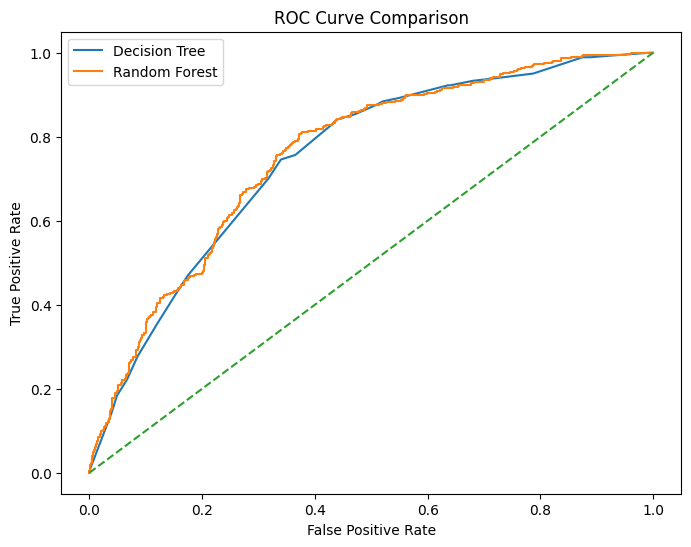

In [9]:
#8. ROC curve analysis


from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

# Probabilities
y_prob_dt = dt_model.predict_proba(X_test)[:, 1]
y_prob_rf = rf_model.predict_proba(X_test)[:, 1]

# ROC data
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_prob_dt)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)

# Plot
plt.figure(figsize=(8,6))
plt.plot(fpr_dt, tpr_dt, label="Decision Tree")
plt.plot(fpr_rf, tpr_rf, label="Random Forest")
plt.plot([0,1], [0,1], linestyle="--")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()


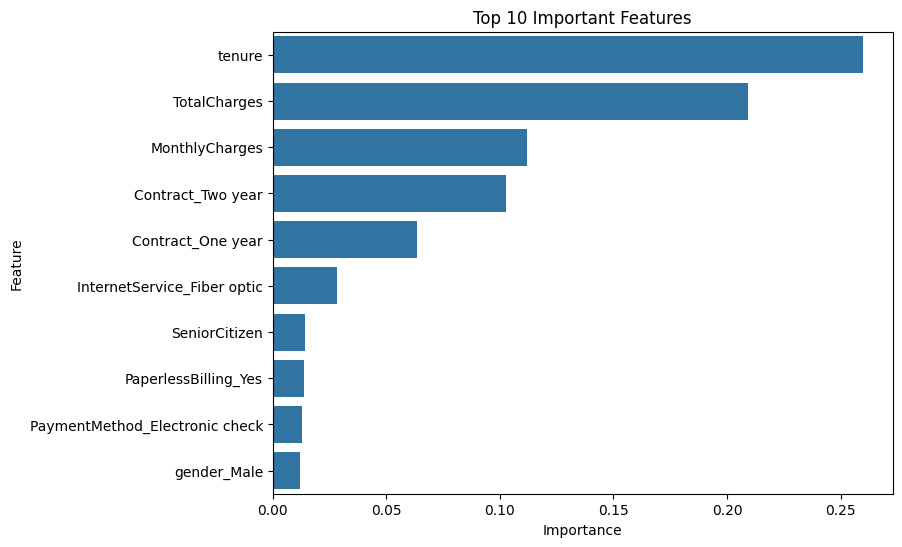

,Feature,Importance
1,tenure,0.259960
3,TotalCharges,0.209246
2,MonthlyCharges,0.111933
25,Contract_Two year,0.102541
24,Contract_One year,0.063296
10,InternetService_Fiber optic,0.028315
0,SeniorCitizen,0.014102
26,PaperlessBilling_Yes,0.013693
28,PaymentMethod_Electronic check,0.012864
4,gender_Male,0.012194


In [11]:
#9.Feature importance (random forest)

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


# Get feature importance
importances = rf_model.feature_importances_
feature_names = X.columns

importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
})

importance_df = importance_df.sort_values(by="Importance", ascending=False).head(10)

plt.figure(figsize=(8,6))
sns.barplot(x="Importance", y="Feature", data=importance_df)
plt.title("Top 10 Important Features")
plt.show()

importance_df
